In [1]:
!pip install audiomentations
!pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 KB 2.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 32.6 MB/s eta 0:00:00


In [2]:
# Utils
import pandas as pd
import numpy as np
import json
import os
import subprocess
import zipfile
import IPython.display as ipd
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

# Library for audio processing
import librosa
import soundfile as sf
from scipy.io.wavfile import write

# Data augmentation
from audiomentations import Compose, TimeStretch, PitchShift, Shift, Gain
import tensorflow as tf
import tensorflow_io as tfio
import cv2

# Visualizations and plots
import matplotlib.pyplot as plt

# Options
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None

# Warnings
import warnings
warnings.filterwarnings('ignore', '.*PySoundFile failed. Trying audioread instead*.', )

# Colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZNK10tensorflow4data11DatasetBase8FinalizeEPNS_15OpKernelContextESt8functionIFN3tsl8StatusOrISt10unique_

Mounted at /content/gdrive


The dataset is characterized by an imbalance of the classes, with the positive class being significantly less populated than the negative class. We want to evaluate the effects of data augmentation as a technique to handle the problem of imbalanced classes.

We propose an approach based on raw signal data augmentation.

For raw signal data augmentation, we use a composition of different operations: TimeStretch, PitchShift, Shift, and Gain. In particular, each operation is assigned a probability of being executed. The PitchShift is assigned a higher probability since many papers emphasize it as being the most useful transformation.

The goal is to generate synthetic observations for the minority class until a 1:3 ratio between the classes is achieved (this is a proportion that most papers in this domain use).

In [3]:
audiotracks = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Metadata/metadata[FINAL].csv')
audiotracks = audiotracks.drop(['Unnamed: 0'], axis = 1)

In [6]:
audiotracks.groupby('COVID19_BI_2').size()

COVID19_BI_2
Negative    11506
Positive      613
dtype: int64

# Example

In [ ]:
augment = Compose([
    TimeStretch(min_rate=0.75, max_rate=1.25, p=0.75),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.9),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.75),
    Gain(p=1)
])

In [ ]:
audio_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Example/audiopreprocessed_example.wav'
audio, sr = librosa.load(audio_path)
ipd.Audio(audio, rate = sr)

In [ ]:
augmented_audio = augment(audio, sr)
sf.write('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Example/augmented_example.wav', augmented_audio, 22050) # Saving the audio track
ipd.Audio(augmented_audio, rate = sr)

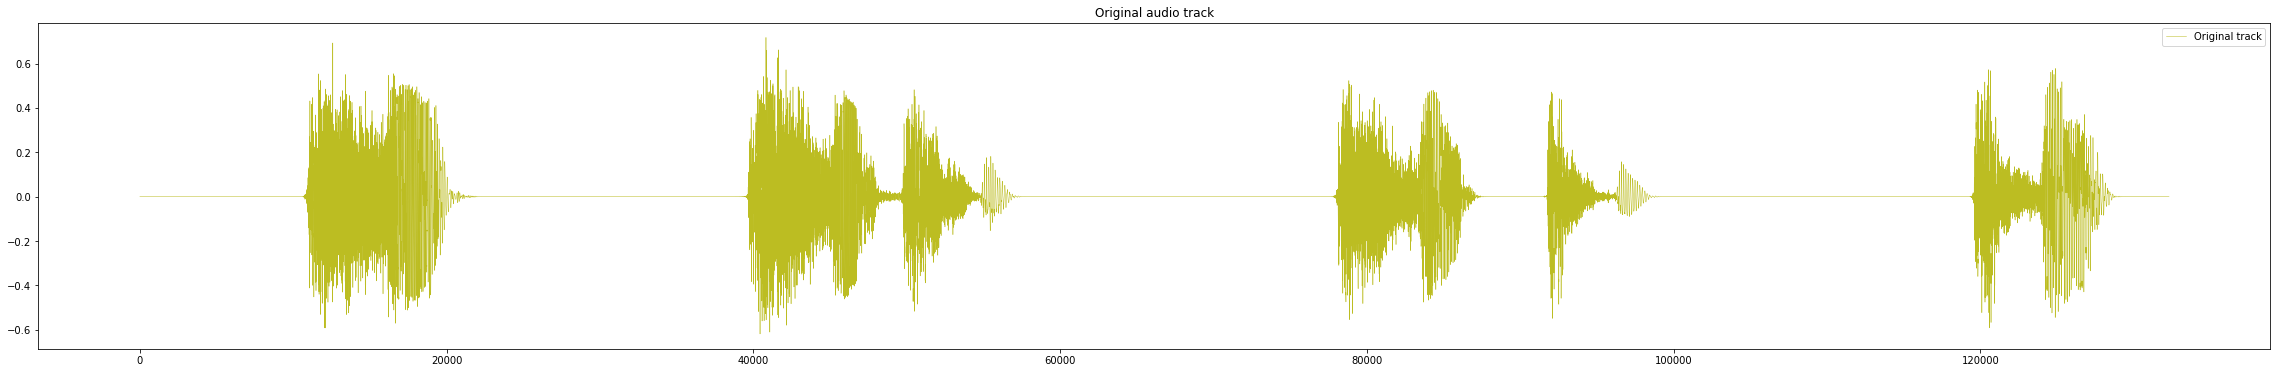

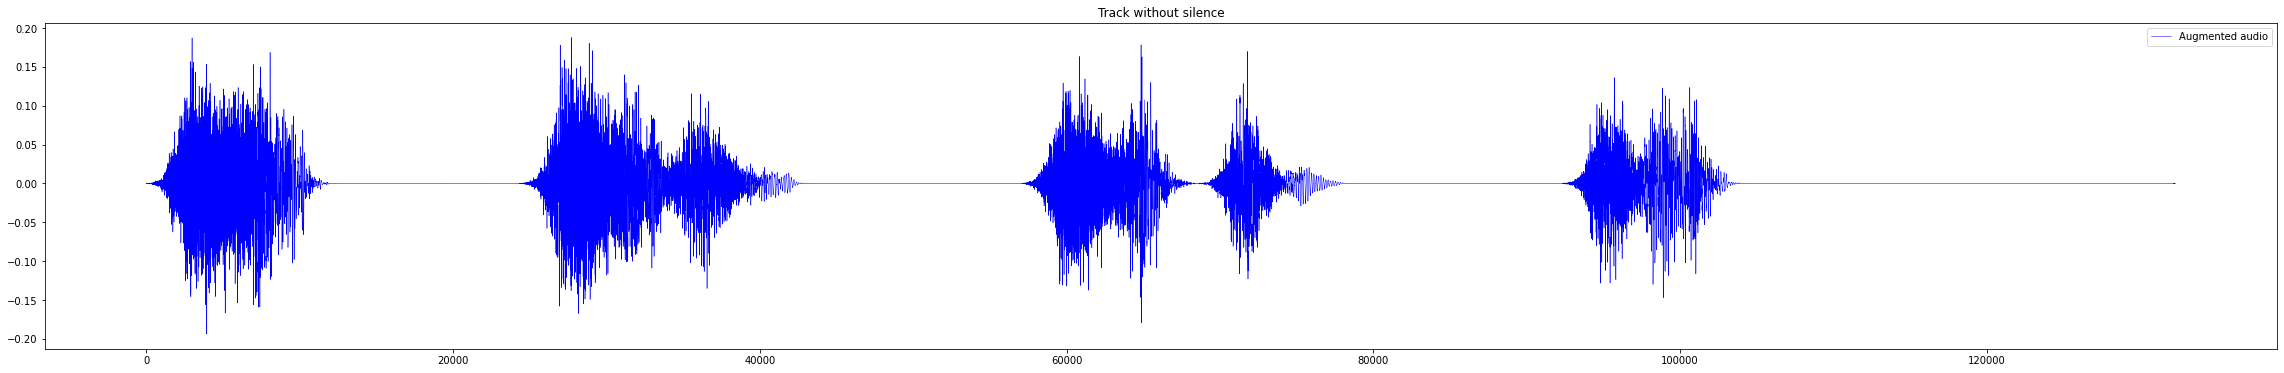

In [ ]:
plt.figure(figsize=(40,6))
plt.plot(audio, color='tab:olive', linewidth=0.5, label = 'Original track')
# plt.hlines(0, 0, 5000,color='black', linewidth=0.7)
plt.title("Original audio track")
plt.legend()
plt.show()

plt.figure(figsize=(40,6))
plt.plot(augmented_audio, color='blue', linewidth=0.5, label = 'Augmented audio')
# plt.hlines(0, 0, 5000, color='black', linewidth=0.7)
plt.title("Augmented audio track")
plt.legend()
plt.show()

# Data augmentation

As we continued working, we realized the problem that the classifier tends to effectively recognize only augmented audio. The ideal approach, however, is one in which augmentation is only applied to the training set, with the validation and test sets left unchanged and representative of the real data distribution. For this reason, we will both increase only the training set, to follow the ideal approach, and increase the entire dataset (following the approach used in several domain papers anyway).

In [ ]:
# Split into train/test set
audiotracks_train, audiotracks_test = train_test_split(audiotracks, test_size=0.2, stratify=audiotracks["COVID19_BI_2"])

In [ ]:
audiotracks_train.reset_index(inplace=True, drop=True)
audiotracks_test.reset_index(inplace=True, drop=True)

In [ ]:
print(audiotracks_train.groupby('COVID19_BI_2').size())
print(audiotracks_test.groupby('COVID19_BI_2').size())

COVID19_BI_2
Negative    9205
Positive     490
dtype: int64
COVID19_BI_2
Negative    2301
Positive     123
dtype: int64


In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugAfterSplit/original_train.csv', 'w', 
          encoding = 'utf-8-sig') as f:
  audiotracks_train.to_csv(f)

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugAfterSplit/original_test.csv', 'w', 
          encoding = 'utf-8-sig') as f:
  audiotracks_test.to_csv(f)

In this case, to reach the desired ratio, the augmentation is applied 5 times for each audio track of the minority class.

### Augmentation on full dataset

In [ ]:
dataset_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/AudioNoNoise/'
write_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/AugmentedData/FinalVersion/AugAllDataset/'

In [ ]:
def rawaudio_augmentation_BI2(audiotracks, audio_datadir, audio_writedir, indexes, aug_names):
  counter = 0
  for index, row in audiotracks.iterrows():
    if row['COVID19_BI_2'] == 'Positive':
      audioname = audio_datadir+row['uuid']
      tmp_audio, tmp_sr = librosa.load(audioname)

      i = 0
      # Performs augmentation x5
      while i < 5:
        writename = audio_writedir+'aug_'+str(i)+'_'+row['uuid']
        aug_names.append('aug_'+str(i)+'_'+row['uuid'])
        indexes.append(index)
        augmented_data = augment(tmp_audio, tmp_sr)
        write(writename, tmp_sr, augmented_data)

        i += 1
        
        counter += 1
        if counter%500==0:
          print('Augmentation counter: ' + str(counter))

In [ ]:
indexes = []
aug_names = []
rawaudio_augmentation_BI2(audiotracks, dataset_path, write_path, indexes, aug_names)

Augmentation counter: 500
Augmentation counter: 1000
Augmentation counter: 1500
Augmentation counter: 2000
Augmentation counter: 2500
Augmentation counter: 3000


In [ ]:
# with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/augmentation_index_fulldata.json', "w") as fp:
#   json.dump(indexes, fp)

# with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/augmentation_names_fulldata.json', "w") as fp:
#   json.dump(aug_names, fp)

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/augmentation_index_fulldata.json', 'rb') as fp:
  indexes = json.load(fp)

with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/augmentation_names_fulldata.json', 'rb') as fp:
  aug_names = json.load(fp)

In [ ]:
# Metadata for augmented audio
augmented_metadata_BI2 = audiotracks.iloc[indexes,:]
augmented_metadata_BI2.insert(1, "new_uuid", aug_names, True)
augmented_metadata_BI2.drop('uuid', axis=1, inplace=True)
augmented_metadata_BI2.rename(columns={'new_uuid':'uuid'}, inplace=True)
augmented_metadata_BI2.reset_index(inplace=True, drop=True)
augmented_metadata_BI2.shape

(3065, 8)

In [ ]:
# with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/augmented_metadata.csv', 'w', 
#           encoding = 'utf-8-sig') as f:
#   augmented_metadata_BI2.to_csv(f)

In [ ]:
augmented_metadata_BI2 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/augmented_metadata.csv')
augmented_metadata_BI2 = augmented_metadata_BI2.drop(['Unnamed: 0'], axis = 1)

In [ ]:
# Metadata for the entire dataset (original audio + augmented)
metadata_complete_BI2 = pd.concat([audiotracks, augmented_metadata_BI2], sort=False)
metadata_complete_BI2.reset_index(inplace=True, drop=True)
metadata_complete_BI2.shape

(15184, 8)

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugBeforeSplit/complete_audiotracks.csv', 'w', 
          encoding = 'utf-8-sig') as f:
  metadata_complete_BI2.to_csv(f)

### Augmentation on train split

In [ ]:
dataset_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/AudioNoNoise/'
write_path = '/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Dataset/AugmentedData/FinalVersion/Split/Train/'

In [ ]:
indexes = []
aug_names = []
rawaudio_augmentation_BI2(audiotracks_train, dataset_path, write_path, indexes, aug_names)

Augmentation counter: 500
Augmentation counter: 1000
Augmentation counter: 1500
Augmentation counter: 2000


In [ ]:
# with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/augmentation_index_splittrain.json', "w") as fp:
#   json.dump(indexes, fp)

# with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/augmentation_names_splittrain.json', "w") as fp:
#   json.dump(aug_names, fp)

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/augmentation_index_splittrain.json.json', 'rb') as fp:
  indexes = json.load(fp)

with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/augmentation_names_splittrain.json', 'rb') as fp:
  aug_names = json.load(fp)

In [ ]:
augmented_metadata_train = audiotracks_train.iloc[indexes,:]
augmented_metadata_train.insert(1, "new_uuid", aug_names, True)
augmented_metadata_train.drop('uuid', axis=1, inplace=True)
augmented_metadata_train.rename(columns={'new_uuid':'uuid'}, inplace=True)
augmented_metadata_train.reset_index(inplace=True, drop=True)
augmented_metadata_train.shape

(2450, 8)

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugAfterSplit/augmented_metadata_train.csv', 'w', 
          encoding = 'utf-8-sig') as f:
  augmented_metadata_train.to_csv(f)

In [ ]:
augmented_metadata_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugAfterSplit/augmented_metadata_train.csv')
augmented_metadata_train = augmented_metadata_train.drop(['Unnamed: 0'], axis = 1)

In [ ]:
metadata_complete_train = pd.concat([audiotracks_train, augmented_metadata_train], sort=False)
metadata_complete_train.reset_index(inplace=True, drop=True)
metadata_complete_train.shape

(12145, 8)

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/DSIM Project/Classification/FinalVersion/AugAfterSplit/complete_audiotracks_train.csv', 'w', 
          encoding = 'utf-8-sig') as f:
  metadata_complete_train.to_csv(f)